In [1]:
# All imports go here
import numpy as np
import copy
import math
import random
import csv
import os
import pandas as pd
from tqdm import tqdm
import pygame
import time
import pickle
import turtle
import matplotlib.pyplot as plt
# from parameters import parameters as p

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Parameters and Hyper Parameters

<details>
    <summary> Simulation Hyperparameters </summary>

## Simulation Hyperparameters:
1) Number_of_experiment : int
2) Number_of_episodes : int
3) Number_of_epochs : int
4) POI_distribution : string
5) Agent_distribution : string
6) Reward_type : int
</details>
<details>
    <summary> Domain Parameters </summary>

## Domain Parameters:
1) X_dimension : float
2) y_dimension : float
3) Number_of_POIs : int
4) Number_of_agents : int
</details>
<details>
    <summary> Fire Parameters </summary>

## Fire Parameters:
1) Value : float
2) Level : int
3) Coupling : int
</details>
<details>
    <summary> Agent Parameters </summary>

## Agent Parameters:
1) Max_step : int
2) Sensor_resolution : float
3) Number_of_sectors : int
4) Sensor_radius : float
</details>
<details>
    <summary> Q-Learning Parameters </summary>

## Q-Learning Parameters:
1) Epsilon : float
2) Epsilon_decay_factor : float
3) Learning_rate : float
4) Discount_factor : float
</details>

___
<details>
    <summary> Functions </summary>

## Functions:
1) 
</details>


In [2]:
parameters = {}
# Domain Params
parameters["x_dim"] = 30.0
parameters["y_dim"] = 30.0
parameters["n_pois"] = 5
parameters["n_agents"] = 3

# Fire Params
parameters["value"] = 100
parameters["level"] = int(2)
parameters["hazard_coupling"] =   {1: {"coupling": 1, "opti_coupling": 1},
                                   2: {"coupling": 2, "opti_coupling": 2},
                                   3: {"coupling": 3, "opti_coupling": 4},
                                   4: {"coupling": 3, "opti_coupling": 5},
                                  }
parameters["coupling"] = int(parameters["hazard_coupling"].get(parameters["level"], 1)["coupling"])
parameters["opti_coupling"] = int(parameters["hazard_coupling"].get(parameters["level"], 1)["opti_coupling"])

# Agent Params
parameters["max_step"] = 1.5
parameters["sensor_res"] = 90.0 # Sector size in degrees
parameters["n_sectors"] = int(360.0 / parameters["sensor_res"])
parameters["sensor_radius"] = 3.0
parameters["observation_size"] = int(2 * parameters["n_sectors"])

# Q-Learning Params
parameters["epsilon"] = 0.7
parameters["epsilon_decay_factor"] = 0.999
parameters["learning_rate"] = 0.1
parameters["discount_factor"] = 0.95

# Simulation Hyperparams
parameters["n_experiments"] = 1
parameters["n_episodes"] = int(2000)
parameters["n_epochs"] = int(800)
parameters["poi_distribution"] = "Random"
parameters["agent_distribution"] = "OneRandom" # OneRandom, AllRandom
parameters["reward_type"] = 2 # 0: Global rewards, 1: Difference Rewards, 2: D++ Rewards
   
    

## Helper Functions

<details>
    <summary>Functions</summary>

## Functions:
1) save_poi_config_csv()
2) save_agent_config_csv()
3) get_angle()
4) get_euclidean_distance()
5) get_squared_distance()
</details>

## Description:


In [3]:
# Helper Functions
def save_poi_config_csv(pois_info, config_id):
    """
    Saves POIs' configuration to a csv file in a folder called World_Config
    """
    dir_name = './Configs'  # Intended directory for output files

    if not os.path.exists(dir_name):  # If Data directory does not exist, create it
        os.makedirs(dir_name)

    pfile_name = os.path.join(dir_name, f'POI_Config{config_id}.csv')

    with open(pfile_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for poi_id in range(len(pois_info)):
            writer.writerow(pois_info[poi_id, :])

    csvfile.close()

def save_agent_config_csv(agent_infos, config_id):
    """
    Saves Agents' configuration to a csv file in a folder called World_Config
    """
    dir_name = './Configs'  # Intended directory for output files

    if not os.path.exists(dir_name):  # If Data directory does not exist, create it
        os.makedirs(dir_name)

    pfile_name = os.path.join(dir_name, f'Agent_Config{config_id}.csv')

    row = np.zeros(3)
    with open(pfile_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for agent_id in range(len(agent_infos)):
            writer.writerow(agent_infos[agent_id, :])

    csvfile.close()

def create_pickle_file(input_data, dir_name, file_name):
    """
    Create a pickle file using provided data in the specified directory
    """
    if not os.path.exists(dir_name):  # If Data directory does not exist, create it
        os.makedirs(dir_name)

    path_name = os.path.join(dir_name, file_name)
    rover_file = open(path_name, 'wb')
    pickle.dump(input_data, rover_file)
    rover_file.close()

def get_angle(source_x, source_y, target_x, target_y, radians=False):
    radian_angle = math.atan2(target_y - source_y, target_x - source_x)
    if radians:
        return radian_angle
    return math.degrees(radian_angle)

def get_euclidean_distance(source_x, source_y, target_x, target_y):
    d = math.sqrt((target_y - source_y)**2 + (target_x - source_x)**2)
    if d < 0.01:
        d = 0.01 
    return d

def get_squared_distance(source_x, source_y, target_x, target_y):
    d =(target_y - source_y)**2 + (target_x - source_x)**2
    if d < 0.0001:
        d = 0.0001 
    return d

def plot_cumulative_rewards_experiment(config_id, cumsum_values):
    plt.figure(figsize=(12, 18))
    values = cumsum_values[config_id]
    # Plot the graph
    plt.plot(values, marker='o', linestyle='-', color='b', label='Global Rewards')
    
    # Add labels and title
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative System Rewards')
    plt.title('Cumulative Rewards vs Episodes')
    
    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.show()
    

## Agent Class

<details>
    <summary> Parameters </summary>

### Parameters:
1) ID : int
2) Location : (x: float, y: float, theta: float)
4) Step_size : float
5) Sensor_radius : float
6) Sensor_resolution : float in degrees.
7) Number_of_sectors : int (360/resolution)
8) Current_observation : ndarray
9) Past_observation : ndarray
10) Action_space (up, down, left, right)
11) Q-table : dict
12) Local_reward : float
13) Current_action_dir : float (angle phi)
14) Learning_rate : float
15) Discount_factor : float
16) Epsilon : float 
17) Snapshot : list (stores parameters that remain same across configs)
</details>


<details>
  <summary> Functions </summary>
    
### Functions:
1) reset()
2) setup_sector_angles()
3) get_sector_from_direction()
4) get_direction_from_sector()
5) move()
6) turn()
7) new_location()
8) update_history()
9) get_Qvalue()
10) set_Qvalue()
11) update_Qvalue()
12) scan_surrounding()
13) scan_for_pois()
14) scan_for_agents()
15) **select_action()**
16) e_greedy()
</details>

### Desciption:


In [4]:
class Agent:
    def __init__(self, agent_id, x_pos, y_pos, theta):
        self.state_size = 8 # (size of the encoding for observations from environment) This needs to change when the actual observation size is known.
        self.agent_id = agent_id
        self.loc = np.array([x_pos, y_pos, theta])
        self.max_step = p["max_step"]
        
        # Sensor specs.
        self.sensor_range = p["sensor_radius"]
        self.sensor_res = p["sensor_res"]
        self.n_sectors = p["n_sectors"]
        self.sector_angles = self.setup_sector_angles()
        
        # MDP params
        self.curr_obs = np.zeros(self.state_size)
        self.prev_obs = np.zeros(self.state_size)
        self.action_space = [i for i in range(self.n_sectors)] # 0 - Front, 1 - Left, 2 - Back, 3 - Right
        self.Qtable = {}
        self.navQtable = {}
        self.l_reward = 0.0
        self.nav_reward = 0.0
        self.curr_action_dir = 0.0
        self.lr = p["learning_rate"]
        self.dscf = p["discount_factor"]

        # Logging info
        self.snap = [self.lr, self.dscf]
        self.path = [self.loc.copy()]

    def reset(self, config):
        self.loc[0] = config[0]
        self.loc[1] = config[1]
        self.loc[2] = config[2]
        self.curr_obs = np.zeros(self.state_size)
        self.prev_obs = self.curr_obs.copy()
        self.l_reward = 0.0
        self.curr_action_dir = 0.0
        self.lr = self.snap[0]
        self.dscf = self.snap[1]
        self.path = [self.loc.copy()]

    def setup_sector_angles(self):
        half = self.sensor_res/2
        angles = []
        n = self.n_sectors
        
        s = 90.0 - half
        for i in range(n):
            angles.append(s)
            s += self.sensor_res
        return angles
        
    def get_sector_from_direction(self, direction):
        # direction should be in range [0, 360)
        # direction = direction - self.loc[2]  # This line will change direction from world coordinate system to local coordiate system.
        if direction < 0:
            while direction < 0:
                direction += 360
        elif direction >= 360:
            while direction >= 360:
                direction -= 360

        for i in range(len(self.sector_angles) - 1):
            if direction >= self.sector_angles[i] and direction < self.sector_angles[i + 1]:
                # print("Quadrant = ", i)
                return i, direction
                
        # print("Quadrant = ", len(self.sector_angles) - 1)
        return len(self.sector_angles) - 1, direction

    def get_direction_from_sector(self, sector):
        direction = self.sector_angles[sector] + self.sensor_res/2
        if direction >= 360.0:
            direction -= 360.0
        rad_angle = math.radians(direction) 
        dir_vector = [math.cos(rad_angle), math.sin(rad_angle)]
        return direction, dir_vector

    def move(self, new_location):
        self.loc[:2] = new_location
        self.update_history()

    def turn(self, new_direction):
        self.loc[2] = new_direction
        self.update_history()

    def new_location(self, new_location):
        self.loc = new_location
        self.update_history()
    
    def update_history(self):
        self.path.append(self.loc.copy())

    def get_observation_mask(self, observation):
        return (observation != -1.0)
    
    def get_navQvalue(self, location, action):
        # For given position and action_sector provide a Q-value
        return self.navQtable.get((tuple(location), action), 0.0)

    def set_navQvalue(self, location, action, value):
        self.navQtable[(tuple(location), action)] = round(value, 10)
    
    def get_Qvalue(self, observation, action):
        return self.Qtable.get((tuple(observation), action), 0.0)

    def set_Qvalue(self, observation, action, value):
        self.Qtable[(tuple(observation), action)] = round(value, 10)

    def update_navQvalue(self):
        curr_Q = self.get_navQvalue(self.loc.tolist(), self.get_sector_from_direction(self.curr_action_dir))
        next_Qs = [self.get_navQvalue(self.loc.tolist(), next_sector) for next_sector in range(self.n_sectors)]
        best_Q = np.max(next_Qs)
        td_error = self.nav_reward + self.dscf * (best_Q - curr_Q)
        new_Q = curr_Q + self.lr * td_error
        self.set_navQvalue(self.path[-1].tolist(), self.get_sector_from_direction(self.curr_action_dir), new_Q)
        self.nav_reward = 0.0
    
    def update_Qvalue(self):
        curr_Q = self.get_Qvalue(self.get_observation_mask(self.curr_obs).tolist(), self.get_sector_from_direction(self.curr_action_dir))
        next_Qs = [self.get_Qvalue(self.get_observation_mask(self.curr_obs).tolist(), next_sector) for next_sector in range(self.n_sectors)]
        best_Q = np.max(next_Qs)
        td_error = self.l_reward + self.dscf * (best_Q - curr_Q)
        new_Q = curr_Q + self.lr * td_error
        # Debug Statement:
        # if self.agent_id == 0:
        #     if new_Q > 0.0:
        #         print(self.get_observation_mask(self.prev_obs).tolist(), ":", new_Q, "\n\n")
        self.set_Qvalue(self.get_observation_mask(self.prev_obs).tolist(), self.get_sector_from_direction(self.curr_action_dir), new_Q)
        self.l_reward = 0.0

    def scan_surrounding(self, agents, pois, distance_table):
        observation_for_pois = self.scan_for_pois(pois, distance_table)
        observation_for_other_agents = self.scan_for_agents(agents)
        self.prev_obs = self.curr_obs.copy()
        self.curr_obs = np.concatenate((observation_for_pois, observation_for_other_agents))
    
    def scan_for_pois(self, pois, dist_table):
        poi_state = np.zeros(self.n_sectors)
        state_mask = np.zeros(self.n_sectors)
        dist_sq_to_pois = dist_table[:, self.agent_id]
        
        detection_radius_sq = self.sensor_range**2
        poi_ids_in_range = np.where(dist_sq_to_pois <= detection_radius_sq)[0]
        # poi_ids_out_range = np.where(dist_sq_to_pois > detection_radius_sq)[0]
        
        for poi_id in poi_ids_in_range:
            poi = pois[poi_id]
            if poi.done:
                continue
            angle = get_angle(self.loc[0], self.loc[1], poi.loc[0], poi.loc[1])
            poi_sector, angle = self.get_sector_from_direction(angle)
            dist_sq = dist_sq_to_pois[poi_id]
            if poi.poi_id in poi_ids_in_range:
                # Detected the POI
                state_mask[poi_sector] = 1
                poi_state[poi_sector] += round(poi.val/dist_sq, 3) 

        for idx in range(self.n_sectors):
            if state_mask[idx] == 0:
                poi_state[idx] = -1
        return poi_state
    
    def scan_for_agents(self, agents):
        agent_state = np.zeros(self.n_sectors)
        state_mask = np.zeros(self.n_sectors)

        x_self, y_self, theta_self = self.loc
        detection_radius_sq = self.sensor_range**2

        for other_agent in agents:
            if other_agent.agent_id == self.agent_id:
                continue

            x_other, y_other, theta_other = other_agent.loc
            dist_sq = (x_other - x_self)**2 + (y_other - y_self)**2
            if dist_sq < 0.01:
                dist_sq = 0.01
            if dist_sq <= detection_radius_sq:
                angle = get_angle(x_self, y_self, x_other, y_other)
                agent_sector, angle = self.get_sector_from_direction(angle)

                state_mask[agent_sector] = 1
                agent_state[agent_sector] += round(1/dist_sq, 3)
        for idx in range(self.n_sectors):
            if state_mask[idx] == 0:
                agent_state[idx] = -1
        return agent_state

    def e_greedy(self, epsilon):
        if np.random.rand() < epsilon:
            # We explore
            angle = np.random.uniform(0.0, 360.0)
            rad_angle = math.radians(angle)
            dir_vector = [math.cos(rad_angle), math.sin(rad_angle)]
            return dir_vector, angle
        else:
            # We exploit
            # q_values = []
            P_max_Qvalue = -1000.0
            N_max_Qvalue = -1000.0
            best_action_sector = None
            N_best_action_sector = None

            # Condition to choose POI_tracking or Navigation behavior.
            if sum(self.curr_obs[:self.n_sectors]) > -self.n_sectors:
                # We have some POI in range.
                # Best action for POI tracking.
                for action in range(self.n_sectors): # Action here is a sector of choice NOT a direction vector.
                    # q_values.append(self.get_Qvalue(self.curr_obs.tolist(), action))
                    Q_val = self.get_Qvalue(self.get_observation_mask(self.curr_obs).tolist(), action)
                    if Q_val > P_max_Qvalue:
                        # found new max value
                        best_action_sector = action
                        P_max_Qvalue = Q_val
                # max_Qvalue = np.max(q_values)
                # best_action_sector = np.argmax(q_values)
            else:
                # We don't have a POI in range, so keep navigating.
                # Best action for navigation.
                for action in range(self.n_sectors): # Action here is a sector of choice NOT a direction vector.
                    # q_values.append(self.get_Qvalue(self.curr_obs.tolist(), action))
                    Q_val = self.get_navQvalue(self.loc.tolist(), action)
                    if Q_val > N_max_Qvalue:
                        # found new max value
                        best_action_sector = action
                        N_max_Qvalue = Q_val
            
            angle, dir_vector = self.get_direction_from_sector(best_action_sector)
            return dir_vector, angle

In [5]:
# def get_sector_from_direction(res, n_sect, direction):
#     # direction should be in range [0, 360)
#     if direction < 0:
#         while direction < 0:
#             direction += 360
#     elif direction >= 360:
#         while direction >= 360:
#             direction -= 360

#     half = res/2
#     angles = []
#     n = n_sect
        
#     s = 90.0 - half
    
#     for i in range(n):
#         angles.append(s)
#         s += res
        
#     flag = False
#     for i in range(len(angles) - 1):
#         if direction >= angles[i] and direction < angles[i + 1]:
#             flag = True
#             print("Quadrant = ", i, direction)
#     if not flag:        
#         if (direction >= 0.0 and direction < angles[0]) or (direction >= angles[-1] and direction < 360): 
#             print("Quadrant = ", len(angles) - 1, direction)
#     print(angles)
#     return angles


# def get_direction_from_sector(angles, res, sector):
#     sector_angles = angles
#     direction = sector_angles[sector] + res/2
    
#     # if sector >= len(sector_angles) - 1:
#     if direction >= 360.0:
#         direction -= 360.0
#     print(direction)
    
# res = 60
# n_sect = int(360/res)
# sect_angles = get_sector_from_direction(res, n_sect, 40)
# for i in range(n_sect):
#     get_direction_from_sector(sect_angles, res, i)

## Point of Interest Class

<details>
    <summary> Parameters </summary>

### Parameters:
1) ID : int
2) Location : (x: float, y: float)
3) Value : float
4) Level : int (what is the hazard level of POI)
5) Coupling : int (minimum number of agents reqired)
6) Detected : int (list of agent_ids that detected the poi)
7) Done : bool (True if it's harvested, False otherwise)
8) **Snapshot : list (stores parameters that stay constant across configs)**
</details>

<details>
  <summary> Functions </summary>
    
### Functions:
1) reset()
2) set_detected()
3) set_done()
</details>

### Desciption:


In [6]:
class POI:
    def __init__(self, poi_id, x_pos, y_pos, value, level, coupling, opti_coupling):
        self.poi_id = int(poi_id)
        self.loc = np.array([x_pos, y_pos])
        self.val = value
        self.level = int(level)
        self.coupling = int(coupling)
        self.opti_coupling = int(opti_coupling)
        self.detected = []
        self.done = False

    def reset(self, config):
        self.loc[0] = config[0]
        self.loc[1] = config[1]
        self.val = config[2]
        self.level = config[3]
        self.coupling = config[4]
        self.opti_coupling = config[5]
        self.detected = []
        self.done = False

    def set_done(self, flag):
        self.done = flag

## Forest Domain Class

<details>
    <summary> Parameters </summary>

### Parameters:
1) X : float
2) Y : float
3) Number of POI : int
4) Number of Agents : int
5) Done : bool (True if all fires are done, False otherwise)
6) Global_rewards : list (one reward for each poi)
7) Agents : list (objects of Agent Class)
8) Agent_configurations : 2D List (stores different positional configurations of Agents) 
9) POIs : list (objects of POI Class)
10) POI_configurations : 2D List (stores different positional configurations of POIs)
11) POI_agent_distances : 2D array of floats (distance squared values for each poi and agent pair)
</details>

<details>
  <summary> Functions </summary>
    
### Functions:
1) reset()
2) **show_simulation_details()**
3) goals_done()
4) create_forest()
5) setup_forest()
6) create_poi_config()
7) create_agent_config()
6) load_poi_config()
7) load_agent_config()
8) update_distance_table()
9) select_joint_action()
10) calculate_global_reward()
11) **calculate_difference_reward()**
12) step()
13) execute()
</details>

### Desciption:

In [7]:
class ForestDomain:
    def __init__(self):
        self.X = p["x_dim"]
        self.Y = p["y_dim"]
        self.n_pois = p["n_pois"]
        self.n_agents = p["n_agents"]
        self.done = False
        self.global_rewards = np.zeros(self.n_pois)
        self.agents = np.empty(self.n_agents, dtype=object)
        self.agent_configs = [[] for _ in range(self.n_agents)]
        self.pois = np.empty(self.n_pois, dtype=object)
        self.poi_configs = [[] for _ in range(self.n_pois)]
        self.distance_table = np.ones((self.n_pois, self.n_agents)) # stores squared eucliedian distances
        
    def reset(self, config_id):
        self.done = False
        self.global_rewards = np.zeros(self.n_pois)
        self.distance_table[:, :] = 1000.0
        for idx, poi in enumerate(self.pois):
            poi.reset(self.poi_configs[idx][config_id])
        for idx, agent in enumerate(self.agents):
            agent.reset(self.agent_configs[idx][config_id])
        
    def goals_done(self):
        for poi in self.pois:
            if poi.done:
                continue
            else:
                return False
        return True

    def create_forest(self, config_id):
        poi_infos = self.create_poi_config()
        save_poi_config_csv(poi_infos, config_id)
        
        agent_infos = self.create_agent_config(poi_infos)
        save_agent_config_csv(agent_infos, config_id)
        
    def setup_forest(self):
        f1 = self.load_poi_config()
        # print(self.pois[:].poi_id)
        f2 = self.load_agent_config()
        if f1 and f2:
            print("Forest Ready.")
            return True
        return False
        
    def create_poi_config(self):
        all_poi_params = np.zeros((self.n_pois, 7)) # (n_pois) X (poi_id, x_pos, y_pos, value, level, coupling, opti_coupling)
        if p["poi_distribution"] == "Random":
            for idx in range(self.n_pois):
                # all_poi_params[idx, 0] = int(idx)
                
                x = random.uniform(0, self.X - 1.0)
                y = random.uniform(0, self.Y - 1.0)
    
                too_close = True
                while too_close:
                    count = 0
                    for i in range(self.n_pois):
                        if i != idx:
                            x_dist = x - all_poi_params[idx, 1]
                            y_dist = y - all_poi_params[idx, 2]
                            dist_sq = x_dist** 2 + y_dist**2
                            min_dist_sq = (p["sensor_radius"] * 2.1)** 2
                            if dist_sq <= min_dist_sq:
                                count += 1
                    if count == 0:
                        too_close = False
                    else:
                        x = random.uniform(0, self.X - 1.0)
                        y = random.uniform(0, self.Y - 1.0)
                all_poi_params[idx, 0] = x
                all_poi_params[idx, 1] = y
                all_poi_params[idx, 2] = p["value"]
                all_poi_params[idx, 3] = p["level"]
                all_poi_params[idx, 4] = p["coupling"]
                all_poi_params[idx, 5] = p["opti_coupling"]
        print("POI Configurations generated.")
        return all_poi_params

    def create_agent_config(self, poi_info):
        all_agent_params = np.zeros((self.n_agents, 4)) # (n_agents) X (agent_id, x_pos, y_pos, theta)
        if p["agent_distribution"] == "OneRandom":
            x_pos = random.uniform(0.0, self.X - 1.0)
            y_pos = random.uniform(0.0, self.Y - 1.0)
            theta = random.uniform(0.0, 360.0)
            buffer = 3.0
            
            too_close = True
            while too_close:
                count = 0
                for poi_idx in range(self.n_pois):
                    x_dist = x_pos - poi_info[poi_idx, 1]
                    y_dist = y_pos - poi_info[poi_idx, 2]
                    dist_sq = x_dist**2 + y_dist**2
                    min_dist_sq = (p["sensor_radius"] * 2.0 + buffer)** 2
                    if dist_sq <= min_dist_sq:
                        count += 1
                
                if count == 0:
                    too_close = False
                else:
                    x_pos = random.uniform(0.0, self.X - 1.0)
                    y_pos = random.uniform(0.0, self.Y - 1.0)
            
            for idx in range(self.n_agents):
                # all_agent_params[idx, 0] = int(idx)
                all_agent_params[idx, 0] = x_pos
                all_agent_params[idx, 1] = y_pos
                all_agent_params[idx, 2] = theta
                
        # elif p["agent_distribution"] == "AllRandom":
        print("Agent Configurations generated.")
        return all_agent_params
    
    def load_poi_config(self):
        for cf_id in range(p["n_experiments"]):
            csv_input = []
            status = False
            with open(f'./Configs/POI_Config{cf_id}.csv', mode='r') as csvfile:
                csv_reader = csv.reader(csvfile, delimiter=',')
                for row in csv_reader:
                    csv_input.append(row)
    
            for idx in range(self.n_pois):
                poi_id = idx #int(float(csv_input[idx][0]))
                x_pos = float(csv_input[idx][0])
                y_pos = float(csv_input[idx][1])
                value = float(csv_input[idx][2])
                level = int(float(csv_input[idx][3]))
                coupling = int(float(csv_input[idx][4]))
                opti_coupling = int(float(csv_input[idx][5]))
                
                if cf_id == 0:
                    self.pois[idx] = POI(poi_id, x_pos, y_pos, value, level, coupling, opti_coupling)
                    
                self.poi_configs[poi_id].append((x_pos, y_pos, value, level, coupling, opti_coupling))

        status = True
        return status

    def load_agent_config(self):
        status = False
        for cf_id in range(p["n_experiments"]):
            csv_input = []
            with open(f'./Configs/Agent_Config{cf_id}.csv', mode='r') as csvfile:
                csv_reader = csv.reader(csvfile, delimiter=',')

                for row in csv_reader:
                    csv_input.append(row)

            for idx in range(self.n_agents):
                agent_id = idx #int(float(csv_input[idx][0]))
                x_pos = float(csv_input[idx][0])
                y_pos = float(csv_input[idx][1])
                theta = float(csv_input[idx][2])

                if cf_id == 0:
                    self.agents[idx] = Agent(agent_id, x_pos, y_pos, theta)

                self.agent_configs[idx].append((x_pos, y_pos, theta))
                
        status = True
        return status

    def update_distance_table(self):
        for poi in self.pois:
            # for each poi
            poi_x, poi_y = poi.loc
            for agent in self.agents:
                a_x, a_y, a_t = agent.loc
                dist_sq = (poi_x - a_x)**2 + (poi_y - a_y)**2
                if dist_sq < 0.01:
                    dist_sq = 0.01
                self.distance_table[poi.poi_id, agent.agent_id] = dist_sq
        '''
        print("ForestDomain:: Distance Table: \n")
        for r in self.distance_table:
            for c in r:
                print(c, " ")
            print("\n")
        '''
    
    def select_joint_action(self, epsilon):
        joint_action = np.zeros((self.n_agents, 2)) # returns x, y direction vector for action taken.
        for agent in self.agents:
            action, angle = agent.e_greedy(epsilon)
            agent.curr_action_dir = angle
            joint_action[agent.agent_id] = action
        return joint_action
    
    def calc_global_reward(self):
        global_reward = np.zeros(self.n_pois)
        # Calculate the global rewards for each POI.
        for poi in self.pois:
            if poi.done:
                continue
            observers = 0
            poi_reward = 0.0
            # Check which agents have detected the POI.
            detection_radius_sq = (p["sensor_radius"]/2.0)**2
            observer_agent_ids = np.where(self.distance_table[poi.poi_id] <= detection_radius_sq)[0]
            observers = len(observer_agent_ids)
            if observers > 0:
                for agent in self.agents:
                    # Provide 20% reward for detecting the poi and give rewards untill poi is not done.
                    if agent.agent_id in observer_agent_ids:
                        if agent.agent_id not in poi.detected:
                            poi.detected.append(agent.agent_id)
                        agent.nav_reward = poi.val * 0.2
                        
            # Get just observer count
            '''
            sorted_dist_sq_from_poi = np.sort(self.distance_table[poi.poi_id])
            for i in range(poi.coupling):
                if sorted_dist_sq_from_poi[i] < detection_radius_sq:
                    observers += 1
             ''' 
            if observers >= int(poi.coupling):
                # We have minimum required agents
                dist_sq_sum = np.sum(np.partition(self.distance_table[poi.poi_id], observers-1)[:observers])
                v = poi.val/dist_sq_sum
                reward_full = v  # Add any other partial rewards gained in the process here.
                optimum_coupling = poi.opti_coupling  # When there is a different optimum value than the minimum, change this. 
                global_reward[poi.poi_id] = reward_full * (np.e/float(optimum_coupling)) * observers * np.exp(-1 * float(observers/optimum_coupling)) 
                poi_status = True
                # If the agent needs to be on the POI's location to complete it. Un-comment the block below. 
                ''' 
                observers_on_poi = 0
                for i in range(observers_in_range):
                    if sorted_dist_sq_from_poi[i] <= 0.001:
                        # Has reached poi
                        continue
                    else:
                        # Atleast 1 is missing.
                        flag = False
                '''
                poi.set_done(poi_status)
        self.global_rewards = global_reward
        
    def calc_difference_reward(self):
        difference_rewards = np.zeros(self.n_agents)
        for agent in self.agents:
            counterfactual = 0.0
            counterfactual_rewards = np.zeros(self.n_pois)
            detection_radius_sq = (agent.sensor_range/2.0)**2
            for poi in self.pois:
                if poi.done:
                    continue
                observers = 0
                observer_agent_ids = np.where(self.distance_table[poi.poi_id] <= detection_radius_sq)[0]
                distances = self.distance_table[poi.poi_id, :]
                agents_in_radius = distances <= detection_radius_sq
                agents_in_radius[agent.agent_id] = False

                observers = np.sum(agents_in_radius)
                if observers > 0:
                    for agent in self.agents:
                        # Provide 20% reward for detecting the poi and give rewards untill poi is not done.
                        if agent.agent_id in observer_agent_ids:
                            if agent.agent_id not in poi.detected:
                                poi.detected.append(agent.agent_id)
                            agent.nav_reward = poi.val * 0.2
                if observers >= poi.coupling:
                    dist_sq_sum = np.sum(distances[agents_in_radius])
                    v = poi.val/dist_sq_sum
                    counterfactual_rewards[poi.poi_id] = v * (np.e / float(poi.opti_coupling)) * observers * np.exp(-1 * float(observers/poi.opti_coupling))
            difference_rewards[agent.agent_id] = np.sum(self.global_rewards - counterfactual_rewards)
        return difference_rewards  

    def calc_difference_plus_plus(self):
        difference_rewards = self.calc_difference_reward()
        dpp_rewards = np.zeros(self.n_agents)
        n_ghost_agents = self.n_agents - 1
        n_ghost_opti = 0
        for agent in self.agents:
            detection_radius_sq = (agent.sensor_range/2.0)**2
            ghost_global = np.zeros(self.n_pois)
            
            n_ghost = 1
            while n_ghost <= n_ghost_agents:
                poi_rewards = np.zeros(self.n_pois)
                for poi in self.pois:
                    if poi.done:
                        continue
                    observers = 0
                    dist_sq = self.distance_table[poi.poi_id]
                    ghost_dist_to_add = np.full(n_ghost, dist_sq[agent.agent_id])
                    dist_sq_ghost = np.append(dist_sq, dist_sq[agent.agent_id])
                    observer_agent_ids = np.where(self.distance_table[poi.poi_id] <= detection_radius_sq)[0]
                    agents_in_radius = dist_sq_ghost <= detection_radius_sq
                    observers = np.sum(agents_in_radius)
                    if observers > 0:
                        for agent in self.agents:
                            # Provide 20% reward for detecting the poi and give rewards untill poi is not done.
                            if agent.agent_id in observer_agent_ids:
                                if agent.agent_id not in poi.detected:
                                    poi.detected.append(agent.agent_id)
                                agent.nav_reward = poi.val * 0.2
                                
                    if observers >= poi.coupling:
                        dist_sq_sum = np.sum(dist_sq_ghost[agents_in_radius])
                        v = poi.val/dist_sq_sum
                        poi_rewards[poi.poi_id] = v * (np.e / float(poi.opti_coupling)) * observers * np.exp(-1 * float(observers/poi.opti_coupling))
                        
                if np.sum(poi_rewards) > np.sum(ghost_global):
                    ghost_global = poi_rewards.copy()
                    n_ghost_opti = n_ghost
                    n_ghost += 1
                else:
                    # Found the optimal in previous iteration.
                    break
            # ghost_global has the global value with n_ghost agents added.
            dpp_rewards[agent.agent_id] = np.sum(ghost_global - self.global_rewards)/(n_ghost_opti + 1.0)
            
        return np.maximum(dpp_rewards, difference_rewards)

    def step(self, joint_action):
        # Take the joint_action
        for agent in self.agents:
            # Calculate displacement.
            dx = 2 * agent.max_step * (joint_action[agent.agent_id, 0] - 0.5)
            dy = 2 * agent.max_step * (joint_action[agent.agent_id, 1] - 0.5)

            # Get new coordinates in world.
            x = np.clip(agent.loc[0] + dx, 0, self.X - 1)
            y = np.clip(agent.loc[1] + dy, 0, self.Y - 1)

            # Move the agent to new position.
            agent.move((x, y))

        # Update Distance table.
        self.update_distance_table()
        
        # Fetch new observations.
        for agent in self.agents:
            agent.scan_surrounding(self.agents, self.pois, self.distance_table)

        # Calculate global reswards for the system after taking this step.
        self.calc_global_reward()

    def execute(self, epsilon, step,  reward_type=0):
        joint_action = self.select_joint_action(epsilon)

        self.step(joint_action)
        reward = np.zeros(self.n_agents)
        match reward_type:
            case 0:
                # Global rewards
                reward = np.full(self.n_agents, np.sum(self.global_rewards))
            case 1:
                # Difference rewards
                reward = self.calc_difference_reward()
                # print("Using Difference Rewards.")
            case 2:
                # D++ rewards
                reward = self.calc_difference_plus_plus()
                # print("Using D++ Rewards.")
            case _:
                print("Incorrect Reward code.")
                
        for agent in self.agents:
            agent.l_reward += reward[agent.agent_id]
            agent.nav_reward += -1
            agent.update_Qvalue()
            agent.update_navQvalue()

In [8]:
# def load_poi_config(n_pois, X, Y, radius, value, level, coupling):
#     all_poi_params = np.zeros((n_pois, 6)) # (n_pois) X (poi_id, x_pos, y_pos, value, level, coupling)
#     pois = np.empty(n_pois, dtype=object)
#     for idx in range(n_pois):
        # all_poi_params[idx, 0] = idx
#         x = random.uniform(0, X - 1.0)
#         y = random.uniform(0, Y - 1.0)

#         too_close = True
#         while too_close:
#             count = 0
#             for i in range(n_pois):
#                 if i != idx:
#                     x_dist = x - all_poi_params[idx, 1]
#                     y_dist = y - all_poi_params[idx, 2]
#                     dist_sq = x_dist** 2 + y_dist**2
#                     min_dist_sq = (radius * 2.1)** 2
#                     if dist_sq < min_dist_sq:
#                         count += 1
#             if count == 0:
#                 too_close = False
#             else:
#                 x = random.uniform(0, X - 1.0)
#                 y = random.uniform(0, Y - 1.0)
#         all_poi_params[idx, 1] = x
#         all_poi_params[idx, 2] = y
#         all_poi_params[idx, 3] = value
#         all_poi_params[idx, 4] = level
#         all_poi_params[idx, 5] = coupling
#         pois[idx] = POI(*all_poi_params[idx])
#     for poi in pois:
#         print(poi.poi_id, poi.loc, poi.val)

# load_poi_config(2, 100.0, 100.0, 3, 100, 1, 2)

In [9]:
# p = parameters

Forest Ready.


Current Episode: 100%|██████████| 10000/10000 [30:34<00:00,  5.45it/s]


Experiment 1/1 completed.
   0     1     2     3     4     5     6     7     8     9     ...  9990  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   9991  9992  9993  9994  9995  9996  9997  9998  9999  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[1 rows x 10000 columns]
333.2054783183054


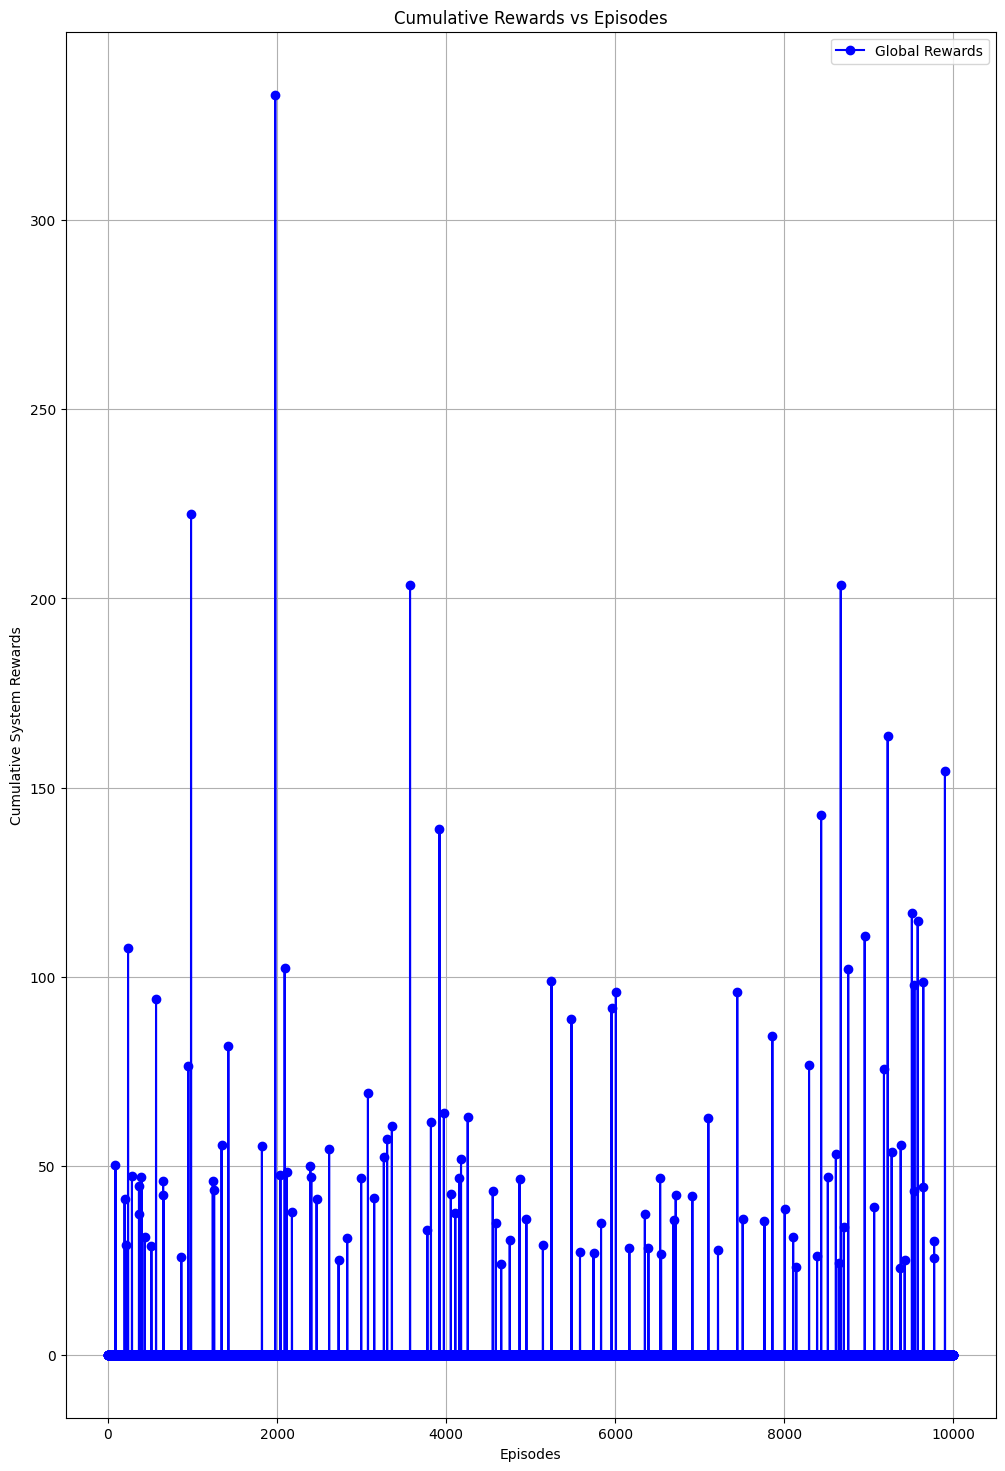

In [10]:

if __name__ == "__main__":
    p = parameters
    domain = ForestDomain()
    paths_taken = [[] for _ in range(p["n_experiments"])]
    cumsum_global_reward = []
    for cf_id in range(p["n_experiments"]):
        domain.create_forest(cf_id)
        
    for cf_id in range(p["n_experiments"]):
        domain.setup_forest()
        # Logging Params
        cumsum_global_rewards_over_experiment = []
        
        for episode in tqdm(range(p["n_episodes"]), desc="Current Episode"):
            # print("**********************\n", domain.agents[0].Qtable.values() if domain.agents[0].Qtable.values() != 0.0 else "", "\n\n\n")
            domain.reset(cf_id)
            # print(domain.agents[0].Qtable.values(), "***********************\n")
            epsilon = p["epsilon"]
            decay = p["epsilon_decay_factor"]
    
            # Logging Params
            global_rewards_over_episode = []
            
            for step in range(p["n_epochs"]):
                domain.execute(epsilon, step, reward_type=p["reward_type"])
                global_rewards_over_episode.append(np.sum(domain.global_rewards))
                if domain.goals_done():
                    break
                epsilon *= decay
                
            cumsum_global_rewards_over_experiment.append(np.cumsum(global_rewards_over_episode)[-1])
    
            if episode == p["n_episodes"] - 1 :
                for agent in domain.agents:
                    paths_taken[cf_id].append(agent.path.copy())
                    # print([(key,": ",value) for key, value in agent.Qtable.items() if value != 0.0], "\n\n")
                    
            # print(f"Episode {episode + 1}/{p["n_episodes"]} completed.")
            
        # if cf_id == p["n_experiments"] - 1:
        cumsum_global_reward.append(cumsum_global_rewards_over_experiment.copy())
        print(f"Experiment {cf_id + 1}/{p["n_experiments"]} completed.")

        # Save agent_paths using pickle
        create_pickle_file(paths_taken[cf_id],"Output_Data/",("EXP{0}_Agent_path").format(cf_id))
        create_pickle_file(cumsum_global_rewards_over_experiment, "Output_Data/", ("EXP{0}_cumulative_G").format(cf_id))
    
    frame = pd.DataFrame(cumsum_global_reward)
    print(frame)
    print(np.max(cumsum_global_reward))
    plot_cumulative_rewards_experiment(0, cumsum_global_reward)
    # print("\n", paths_taken)


In [11]:
# plot_cumulative_rewards_experiment(0, cumsum_global_reward)

# Visualization 

We have used PyGame to visualize the simulation of agents in the world.

<details>
    <summary> Parameters </summary>

### Parameters:
1) 
</details>

<details>
  <summary> Functions </summary>

### Functions:
1)
</details>

pygame.init()

# Window dimensions
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Rover Domain Simulation")

WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)


import pygame

# Initialize Pygame
pygame.init()

# Window dimensions
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Rover Domain Simulation")

# Colors
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
RED = (255, 0, 0)

# Load a fire image for the POI
fire_image = pygame.image.load("fire.png")  # Replace with your fire image path
fire_image = pygame.transform.scale(fire_image, (30, 30))  # Scale to desired size


class POI:
    def __init__(self, x, y, coupling_required):
        self.x = x
        self.y = y
        self.coupling_required = coupling_required  # Number of agents required
        self.agents_at_poi = set()  # Track agents currently at the POI
        self.active = True

    def check_coupling(self):
        """Check if the coupling requirement is satisfied."""
        if len(self.agents_at_poi) >= self.coupling_required:
            self.active = False

    def draw(self, screen):
        """Draw the POI if active."""
        if self.active:
            screen.blit(fire_image, (self.x, self.y))


class Rover:
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id  # Unique identifier for the rover
        self.color = BLUE
        self.size = 20

    def move(self, dx, dy):
        self.x += dx
        self.y += dy

    def draw(self, screen):
        pygame.draw.rect(screen, self.color, pygame.Rect(self.x, self.y, self.size, self.size))

    def is_at_poi(self, poi):
        """Check if the rover is at the POI."""
        return (
            poi.x <= self.x <= poi.x + 30 and
            poi.y <= self.y <= poi.y + 30
        )


def run_simulation():
    # Initialize rovers and POI
    rovers = [Rover(100, 100, id=1), Rover(200, 200, id=2)]  # Multiple rovers
    poi = POI(400, 300, coupling_required=2)  # POI requiring 2 agents

    clock = pygame.time.Clock()

    running = True
    while running:
        screen.fill(WHITE)  # Clear screen

        # Handle events (e.g., closing the window)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Control rover movement (use arrow keys for the first rover, WASD for the second)
        keys = pygame.key.get_pressed()
        if keys[pygame.K_LEFT]:
            rovers[0].move(-5, 0)
        if keys[pygame.K_RIGHT]:
            rovers[0].move(5, 0)
        if keys[pygame.K_UP]:
            rovers[0].move(0, -5)
        if keys[pygame.K_DOWN]:
            rovers[0].move(0, 5)

        if keys[pygame.K_a]:
            rovers[1].move(-5, 0)
        if keys[pygame.K_d]:
            rovers[1].move(5, 0)
        if keys[pygame.K_w]:
            rovers[1].move(0, -5)
        if keys[pygame.K_s]:
            rovers[1].move(0, 5)

        # Check which rovers are at the POI
        poi.agents_at_poi = {rover.id for rover in rovers if rover.is_at_poi(poi)}
        poi.check_coupling()

        # Draw the rovers and POI
        for rover in rovers:
            rover.draw(screen)

        poi.draw(screen)

        # Update the display
        pygame.display.update()

        # Limit frame rate
        clock.tick(30)

    pygame.quit()


if __name__ == "__main__":
    run_simulation()


In [12]:
def import_agent_paths(config_id):
    """
    Import rover paths from pickle file
    :return:
    """
    dir_name = 'Output_Data/'
    file_name = f'EXP{config_id}_Agent_path'
    rover_path_file = os.path.join(dir_name, file_name)
    infile = open(rover_path_file, 'rb')
    rover_paths = pickle.load(infile)
    infile.close()

    return rover_paths

def import_poi_information(n_poi, config_id):
    """
    Import POI information from saved configuration files
    :return:
    """
    pois = np.zeros((n_poi, 6))

    config_input = []
    with open(f'./Configs/POI_Config{config_id}.csv') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')

        for row in csv_reader:
            config_input.append(row)

    for poi_id in range(n_poi):
        pois[poi_id, 0] = float(config_input[poi_id][0])
        pois[poi_id, 1] = float(config_input[poi_id][1])
        pois[poi_id, 2] = float(config_input[poi_id][2])
        pois[poi_id, 3] = float(config_input[poi_id][3])
        pois[poi_id, 4] = float(config_input[poi_id][4])
        pois[poi_id, 5] = float(config_input[poi_id][5])
    return pois

def stop_viz(screen):
    screen.bye()

p = parameters

def run_agent_visualizer(config_id):
    # Define screen parameters for the
    screen_width = p["x_dim"]*10
    screen_height = p["y_dim"]*10
    screen = turtle.Screen()
    screen.setup(screen_width+20, screen_height+20)  # define pixel width and height of screen
    screen.title("Rover Domain")
    screen.bgcolor("white")
    screen.tracer(0)
    
    rovers = []
    rover_paths = import_agent_paths(config_id)
    for rov_id in range(p["n_agents"]):
        rovers.append(turtle.Turtle())
        rovers[rov_id].shape("circle")
        rovers[rov_id].shapesize(10 / 20)  # Number of pixels you want / 20 (default size)
        rovers[rov_id].color("#{:02X}{:02X}{:02X}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

    pois = []
    poi_info = import_poi_information(p["n_pois"], config_id)
    for poi_id in range(p["n_pois"]):
        pois.append(turtle.Turtle())
        pois[poi_id].shape("triangle")
        pois[poi_id].shapesize(20 / 20)  # Number of pixels you want / 20 (default size)
        pois[poi_id].color("red")
        pois[poi_id].penup()
        # Convert rover units to pixel units used by screen
        px = ((poi_info[poi_id, 0]/p["x_dim"]) * screen_width) - (screen_width/2)
        py = ((poi_info[poi_id, 1]/p["y_dim"]) * screen_height) - (screen_height/2)
        pois[poi_id].goto(px, py)
        pois[poi_id].stamp()

    # for srun in range(p["n_episodes"]):
    for tstep in range(p["n_epochs"]):
        screen.title(f"Rover Domain{tstep}")
        for rov_id in range(p["n_agents"]):
            rovers[rov_id].clearstamps()
            rovx = ((rover_paths[rov_id][tstep][0]/p["x_dim"])*screen_width) - (screen_width/2)
            rovy = ((rover_paths[rov_id][tstep][1]/p["y_dim"])*screen_height) - (screen_height/2)
            rovers[rov_id].goto(rovx, rovy)
            rovers[rov_id].stamp()
        screen.update()
        time.sleep(1.0/30)
        
    # screen.listen()  # Set the screen to listen for key presses
    # screen.onkeypress(stop_viz(screen), "q")
    turtle.done()

In [13]:
run_agent_visualizer(0)

In [14]:
# val = 0.3

In [15]:
# val *= 0.999
# val

In [16]:
# def get_observation_mask(observation):
#     mask = (observation != -1.0)
#     return mask

# np.sum((get_observation_mask(np.array([0.2, -1, -1, 0.0, -0.9]))).tolist())